In [17]:
from pathlib import Path

import fsspec
import rioxarray
import xarray as xr

from pyproj import CRS, Transformer

from notebooks.utils import plot_ims_snow_and_ice

DATAPATH = Path.home() / "src" / "rain_on_snow_database" / "data" / "test_data"

fs = fsspec.filesystem('file')

wgs84 = CRS.from_epsg(4326)

In [2]:
filepath = DATAPATH / "ims2023032_4km_v1.3.nc.gz"

ds_4km = xr.open_dataset(fs.open(filepath, compression="gzip"), decode_coords="all")
ds_4km

<xarray.Dataset> Size: 151MB
Dimensions:             (x: 6144, y: 6144, time: 1)
Coordinates:
  * x                   (x) float32 25kB -1.229e+07 -1.228e+07 ... 1.229e+07
  * y                   (y) float32 25kB -1.229e+07 -1.228e+07 ... 1.229e+07
  * time                (time) datetime64[ns] 8B 2023-02-01
    projection          |S1 1B ...
Data variables:
    IMS_Surface_Values  (time, y, x) float32 151MB ...
Attributes: (12/49)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NESDIS Interactive Multisensor Snow and ...
    summary:                    This file contains a map of snow cover and ic...
    keywords:                   EARTH SCIENCE > CRYOSPHERE > SEA ICE > ICE EX...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Ke...
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    ...                         ...
    metadata_link:              https://nsidc.org/data/G02156
    naming_authority:           org.nsidc
    references:                 Ramsay, B. H. (1998). The interactive multise...
    history:                    01 February 2023 00:33Z: NetCDF file generate...
    source:                     Analysts at the United States National Ice Ce...
    comment:                    The IMS product has changed versions and reso...

The plot function overrides the dataset CRS because this is incorrectly defined

<GeoAxes: title={'center': 'time = 2023-02-01, projection = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

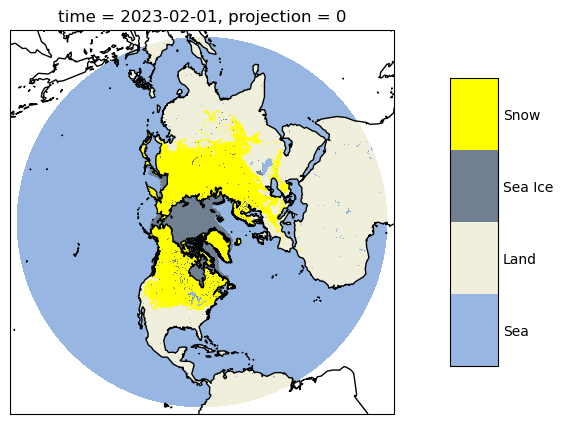

In [3]:
plot_ims_snow_and_ice(ds_4km.IMS_Surface_Values.squeeze())

The user guide states that the 4 km and 1 km data are on a WGS84 ellipsoid.  However, the `semi_minor_axis` in the `projection` variable is not for WGS84.

In [4]:
ds_4km.projection.attrs

{'grid_mapping_name': 'polar_stereographic',
 'latitude_of_projection_origin': 90.0,
 'straight_vertical_longitude_from_pole': -80.0,
 'standard_parallel': 60.0,
 'false_easting': 0.0,
 'false_northing': 0.0,
 'semi_major_axis': 6378137.0,
 'semi_minor_axis': 6356257.0,
 'units': 'm',
 'proj4': '+proj=stere +lat_0=90 +lat_ts=60 +lon_0=-80 +k=1 +x_0=0 +y_0=0 +a=6378137 +b=6356257 +units=m +no_defs',
 'spatial_ref': 'PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6378137,291.505347349177]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",60],PARAMETER["central_meridian",-80],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH]]'}

In [5]:
print(wgs84.ellipsoid.semi_major_metre)
print(wgs84.ellipsoid.semi_minor_metre)

6378137.0
6356752.314245179


In [6]:
ds_4km.projection.attrs["semi_major_axis"] == wgs84.ellipsoid.semi_major_metre

True

In [7]:
ds_4km.projection.attrs["semi_minor_axis"] == wgs84.ellipsoid.semi_minor_metre

False

## Compare projected coordinates

I compare the grid coordinates in the data file with grid coordinates calculated from grid parameters in `Ims4km.gpd`

In [8]:
from ros_database.ims_snow.ims_crs import IMS4kmGrid

In [9]:
x, y = IMS4kmGrid.xy_coords()

In [10]:
assert (x == ds_4km.x).all()

In [11]:
assert (y == ds_4km.y).all()

So the `x` and `y` coordinates are the same, and the gpd file grid parameters are correct.

In [24]:
FileCRS = CRS.from_wkt(ds_4km.rio.crs.to_wkt())
transformer = Transformer.from_crs(FileCRS, wgs84, always_xy=True)

In [28]:
from itertools import product
xmin, ymin, xmax, ymax = ds_4km.rio.bounds()
corners = [(x, y) for x, y in product([xmin, xmax], [ymin, ymax])]
[transformer.transform(x, y) for x, y in corners] 

[(-125.00000000000001, -21.500657784407288),
 (145.0, -21.500657784407288),
 (-35.0, -21.500657784407288),
 (55.0, -21.500657784407288)]

In [29]:
xmin, ymin, xmax, ymax = IMS4kmGrid.bounds()
corners = [(x, y) for x, y in product([xmin, xmax], [ymin, ymax])]
[transformer.transform(x, y) for x, y in corners]

[(-125.00000000000001, -21.500657784407288),
 (145.0, -21.500657784407288),
 (-35.0, -21.500657784407288),
 (55.0, -21.500657784407288)]